# Section 8: Overfitting and cross-validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Cross-validation -- manual separation

In [2]:
iris = sns.load_dataset('iris')
X = torch.tensor(iris[iris.columns[0:4]].values).float()
y = torch.zeros(len(X), dtype=torch.long)
y[iris.species == 'versicolor'] = 1
y[iris.species == 'virginica'] = 2

In [3]:
y_len = len(y)
training_proportion = .8
training_nr = int(y_len * training_proportion)
is_in_training = np.zeros(y_len, dtype=bool)
# is_in_training[range(training_nr)] = True
training_indices = np.random.choice(range(len(y)), training_nr, replace=False)
is_in_training[training_indices] = True

is_in_training

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False, False, False,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,

In [4]:
print("Average of full data:")
print(torch.mean(y.float()))
print()

print("Average of training data:")
print(torch.mean(y[is_in_training].float()))
print()

print("Average of test data:")
print(torch.mean(y[~is_in_training].float()))

Average of full data:
tensor(1.)

Average of training data:
tensor(0.9333)

Average of test data:
tensor(1.2667)


In [5]:
ann_iris = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ann_iris.parameters(), .01)

In [6]:
print(X.shape)
print(X[is_in_training, :].shape)
print(X[~is_in_training, :].shape)

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])


In [7]:
epochs = 1000
losses = torch.zeros(epochs)
accuracies = []

for epoch in range(epochs):
    y_pred = ann_iris(X[is_in_training, :])
    correct_y = torch.argmax(y_pred, axis=1) == y[is_in_training]
    
    accuracies.append(100 * torch.mean(correct_y.float()))
    
    loss = loss_function(y_pred, y[is_in_training])
    losses[epoch] = loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [8]:
y_pred = ann_iris(X[is_in_training, :])
correct_y = torch.argmax(y_pred, axis=1) == y[is_in_training]
train_accuracy = 100 * torch.mean(correct_y.float())

y_pred = ann_iris(X[~is_in_training, :])
correct_y = torch.argmax(y_pred, axis=1) == y[~is_in_training]
test_accuracy = 100 * torch.mean(correct_y.float())

In [9]:
print("Final train accuracy: %g%%" %train_accuracy)
print("Final test accuracy: %g%%" %test_accuracy)

Final train accuracy: 99.1667%
Final test accuracy: 93.3333%


## Cross-validation -- scikitlearn

In [10]:
X_fake = np.tile(np.array([1, 2, 3, 4]), (10, 1)) + np.tile(10 * np.arange(1, 11), (4, 1)).T
y_fake = np.arange(10) > 4

print(X_fake)
print(y_fake)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
[False False False False False  True  True  True  True  True]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_fake, y_fake, test_size=.2)

In [12]:
print("Training data size: " + str(X_train.shape))
print("Test data size: " + str(X_test.shape))

print("Training data:")
print(X_train)
print()

print("Test data:")
print(X_test)
print()

Training data size: (8, 4)
Test data size: (2, 4)
Training data:
[[ 61  62  63  64]
 [ 31  32  33  34]
 [ 91  92  93  94]
 [ 11  12  13  14]
 [101 102 103 104]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 51  52  53  54]]

Test data:
[[41 42 43 44]
 [21 22 23 24]]



In [13]:
def create_model():
    ann_iris_local = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )
    loss_function_local = nn.CrossEntropyLoss()
    optimizer_local = torch.optim.SGD(ann_iris_local.parameters(), .01)
    
    return ann_iris_local, loss_function_local, optimizer_local

def train_model(ann_iris_param, loss_function_param, optimizer_param, training_proportion_param, epochs_param):
    accuracies_train = []
    accuracies_test = []
    
    for epoch_local in range(epochs_param):
        X_train_local, X_test_local, y_train_local, y_test_local = train_test_split(X, y, train_size=training_proportion_param)
        y_pred_local = ann_iris_param(X_train_local)
        loss_local = loss_function_param(y_pred_local, y_train_local)
        
        optimizer_param.zero_grad()
        loss_local.backward()
        optimizer_param.step()
        
        correct_train_y = torch.argmax(y_pred_local, axis=1) == y_train_local
        correct_test_y = torch.argmax(ann_iris_param(X_test_local), axis=1) == y_test_local
            
        accuracies_train.append(100 * torch.mean(correct_train_y.float()))
        accuracies_test.append(100 * torch.mean(correct_test_y.float()))
        
    return accuracies_train, accuracies_test

epochs = 200

In [14]:
ann_iris, loss_function, optimizer = create_model()
train_accuracy, test_accuracy = train_model(ann_iris, loss_function, optimizer, .8, epochs)

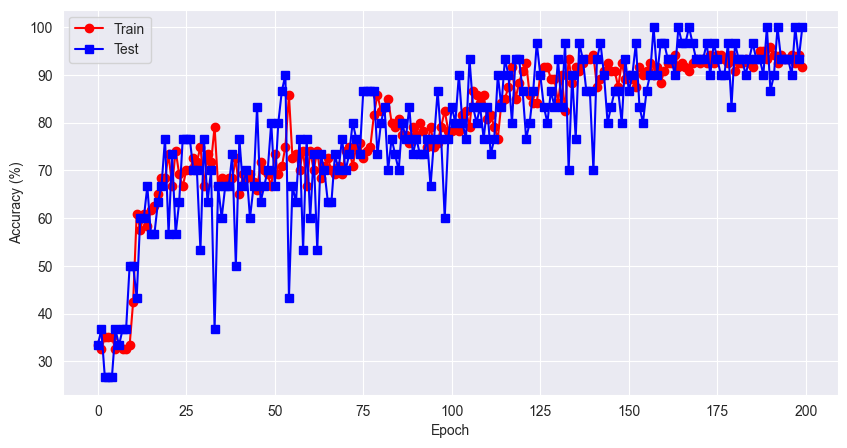

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, 'ro-')
plt.plot(test_accuracy, 'bs-')
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.legend(['Train', 'Test'])
plt.show()

In [16]:
training_proportions = np.linspace(.2, .95, 10)
all_accuracies_train = np.zeros((len(training_proportions), epochs))
all_accuracies_test = np.zeros((len(training_proportions), epochs))

for i, training_proportion in enumerate(training_proportions):
    ann_iris, optimizer, loss_function = create_model()
    accuracies_train_local, accuracies_test_local = train_model(ann_iris, optimizer, loss_function, training_proportion, epochs)
    
    all_accuracies_train[i, :] = accuracies_train_local
    all_accuracies_test[i, :] = accuracies_test_local

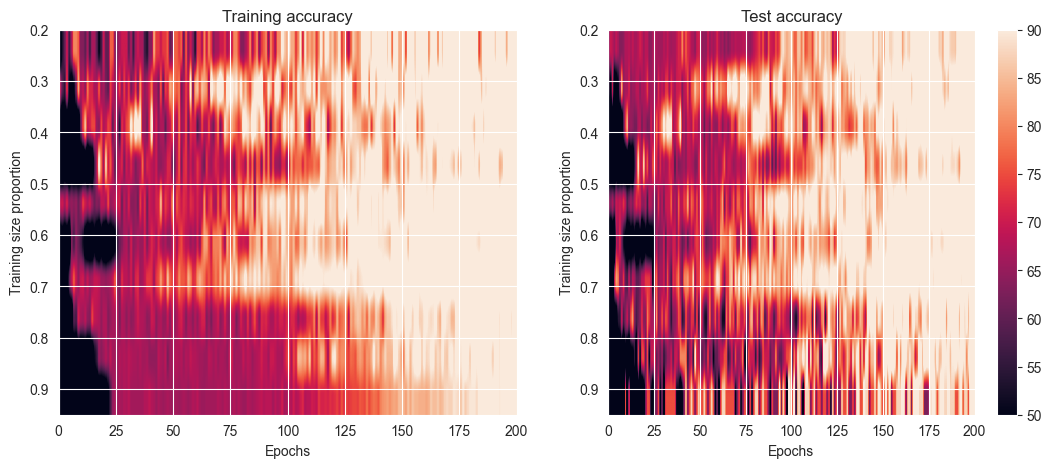

In [17]:
fig, ax = plt.subplots(1 , 2, figsize=(13, 5))

ax[0].imshow(all_accuracies_train, aspect='auto', vmin=50, vmax=90, extent=[0, epochs, training_proportions[-1], training_proportions[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel("Training size proportion")
ax[0].set_title("Training accuracy")

p = ax[1].imshow(all_accuracies_test, aspect='auto', vmin=50, vmax=90, extent=[0, epochs, training_proportions[-1], training_proportions[0]])

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel("Training size proportion")
ax[1].set_title("Test accuracy")
fig.colorbar(p, ax=ax[1])
plt.show()

## Cross-validation -- DataLoader

In [18]:
fake_data_loader = DataLoader(X_fake, shuffle=True)

print(fake_data_loader)
print(fake_data_loader.batch_size)

1


In [19]:
for i, one_fake_data in enumerate(fake_data_loader):
    print(i, one_fake_data, one_fake_data.shape)

0 tensor([[51, 52, 53, 54]]) torch.Size([1, 4])
1 tensor([[41, 42, 43, 44]]) torch.Size([1, 4])
2 tensor([[71, 72, 73, 74]]) torch.Size([1, 4])
3 tensor([[11, 12, 13, 14]]) torch.Size([1, 4])
4 tensor([[91, 92, 93, 94]]) torch.Size([1, 4])
5 tensor([[21, 22, 23, 24]]) torch.Size([1, 4])
6 tensor([[81, 82, 83, 84]]) torch.Size([1, 4])
7 tensor([[101, 102, 103, 104]]) torch.Size([1, 4])
8 tensor([[61, 62, 63, 64]]) torch.Size([1, 4])
9 tensor([[31, 32, 33, 34]]) torch.Size([1, 4])


In [20]:
fake_dataset = TensorDataset(torch.Tensor(X_fake), torch.Tensor(y_fake))

print(fake_dataset.tensors)

(tensor([[ 11.,  12.,  13.,  14.],
        [ 21.,  22.,  23.,  24.],
        [ 31.,  32.,  33.,  34.],
        [ 41.,  42.,  43.,  44.],
        [ 51.,  52.,  53.,  54.],
        [ 61.,  62.,  63.,  64.],
        [ 71.,  72.,  73.,  74.],
        [ 81.,  82.,  83.,  84.],
        [ 91.,  92.,  93.,  94.],
        [101., 102., 103., 104.]]), tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]))


In [21]:
fake_data_loader = DataLoader(fake_dataset, shuffle=True)

for one_x, one_y in fake_data_loader:
    print(one_x, one_y)

tensor([[61., 62., 63., 64.]]) tensor([1.])
tensor([[71., 72., 73., 74.]]) tensor([1.])
tensor([[91., 92., 93., 94.]]) tensor([1.])
tensor([[21., 22., 23., 24.]]) tensor([0.])
tensor([[11., 12., 13., 14.]]) tensor([0.])
tensor([[81., 82., 83., 84.]]) tensor([1.])
tensor([[41., 42., 43., 44.]]) tensor([0.])
tensor([[51., 52., 53., 54.]]) tensor([0.])
tensor([[31., 32., 33., 34.]]) tensor([0.])
tensor([[101., 102., 103., 104.]]) tensor([1.])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_fake, y_fake, test_size=.2)
X_y_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
X_y_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = DataLoader(X_y_train, batch_size=4)
test_loader = DataLoader(X_y_test)

In [23]:
for x_batch, y_batch in train_loader:
    print(x_batch, y_batch)
    
print()

for x_batch, y_batch in test_loader:
    print(x_batch, y_batch)

tensor([[71., 72., 73., 74.],
        [41., 42., 43., 44.],
        [61., 62., 63., 64.],
        [81., 82., 83., 84.]]) tensor([1., 0., 1., 1.])
tensor([[101., 102., 103., 104.],
        [ 21.,  22.,  23.,  24.],
        [ 11.,  12.,  13.,  14.],
        [ 51.,  52.,  53.,  54.]]) tensor([1., 0., 0., 0.])

tensor([[31., 32., 33., 34.]]) tensor([0.])
tensor([[91., 92., 93., 94.]]) tensor([1.])


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_y_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
X_y_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(X_y_train, batch_size=12)
test_loader = DataLoader(X_y_test, batch_size=X_y_test.tensors[0].shape[0])

In [25]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    
print()

for x_batch, y_batch in test_loader:
    print(x_batch.shape, y_batch.shape)

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])

torch.Size([30, 4]) torch.Size([30])


In [26]:
def train_and_test_model(ann_iris_param, loss_function_param, optimizer_param, train_loader, test_loader, epochs_param):
    accuracies_train = []
    accuracies_test = []
    
    for epoch_local in range(epochs_param):
        accuracies_batch = []
        
        for X_train_local, y_train_local in train_loader:
            y_pred_local = ann_iris_param(X_train_local)
            loss_local = loss_function_param(y_pred_local, y_train_local)
            
            optimizer_param.zero_grad()
            loss_local.backward()
            optimizer_param.step()
            
            correct_train_y = torch.argmax(y_pred_local, axis=1) == y_train_local

            accuracies_batch.append(100 * torch.mean(correct_train_y.float()))
    
        accuracies_train.append(np.mean(accuracies_batch))    
        
        X_test_local, y_test_local = next(iter(test_loader))
        y_final_pred_local = ann_iris_param(X_test_local)
        correct_test_y = torch.argmax(y_final_pred_local, axis=1) == y_test_local
    
        accuracies_test.append(100 * torch.mean(correct_test_y.float()))
    
    return accuracies_train, accuracies_test

epochs = 500

In [27]:
ann_iris, loss_function, optimizer = create_model()
train_accuracy, test_accuracy = train_and_test_model(ann_iris, loss_function, optimizer, train_loader, test_loader, epochs)

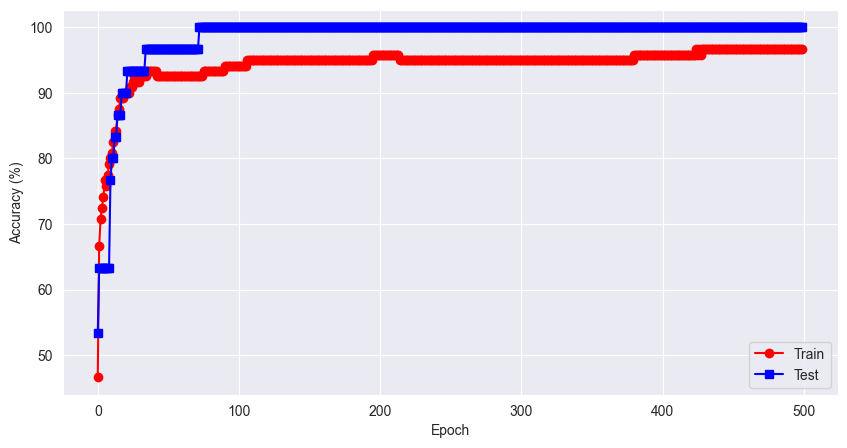

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, 'ro-')
plt.plot(test_accuracy, 'bs-')
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.legend(['Train', 'Test'])
plt.show()

## Splitting data into train, devset, test

In [29]:
partitions = [.8, .1, .1]

X_train, X_val_test, y_train, y_val_test = train_test_split(X_fake, y_fake, train_size=partitions[0])
split = partitions[1] / np.sum(partitions[1:])
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=split)

print(f"Training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Test data size: {X_test.shape}")
print()
print("Training data:")
print(X_train)
print()
print("Validation data:")
print(X_val)
print()
print("Test data:")
print(X_test)

Training data size: (8, 4)
Validation data size: (1, 4)
Test data size: (1, 4)

Training data:
[[ 31  32  33  34]
 [ 91  92  93  94]
 [ 41  42  43  44]
 [ 11  12  13  14]
 [ 51  52  53  54]
 [101 102 103 104]
 [ 21  22  23  24]
 [ 61  62  63  64]]

Validation data:
[[71 72 73 74]]

Test data:
[[81 82 83 84]]


## Cross-validation on regression

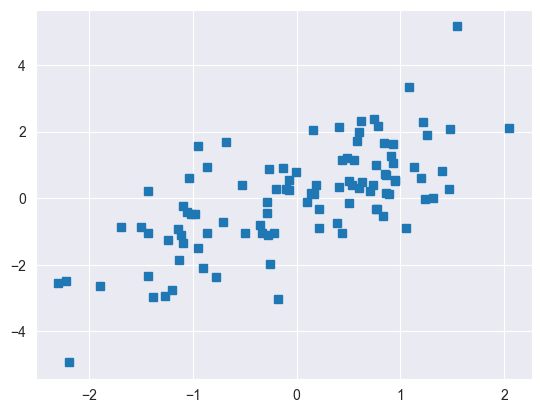

In [30]:
N = 100
X = torch.randn(N, 1)
y = X + torch.randn(N, 1)

plt.plot(X, y, 's')
plt.show()

In [31]:
ann_regression = nn.Sequential(
    nn.Linear(1, 1),
    nn.ReLU(),
    nn.Linear(1, 1),
)
learning_rate = .05
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(ann_regression.parameters(), learning_rate)

In [32]:
training_proportion = int((N * 80) / 100)
training_indices = np.random.choice(range(N), training_proportion, replace=False)
is_in_training = np.zeros(N, dtype=bool)
is_in_training[training_indices] = True

print(X[is_in_training].shape)
print(X[~is_in_training].shape)

torch.Size([80, 1])
torch.Size([20, 1])


In [33]:
epochs = 500
losses_train = []
losses_test = []

for epoch in range(epochs):
    y_pred_train = ann_regression(X[is_in_training])
    loss_train_local = loss_function(y_pred_train, y[is_in_training])

    optimizer.zero_grad()
    loss_train_local.backward()
    optimizer.step()
    
    y_pred_test = ann_regression(X[~is_in_training])
    loss_test_local = loss_function(y_pred_test, y[~is_in_training])
    
    losses_train.append(loss_train_local.detach())
    losses_test.append(loss_test_local.detach())

In [34]:
print(f"Final train loss: {losses_train[-1].detach():.2f}")
print(f"Final test loss: {losses_test[-1].detach():.2f}")

Final train loss: 1.27
Final test loss: 1.10


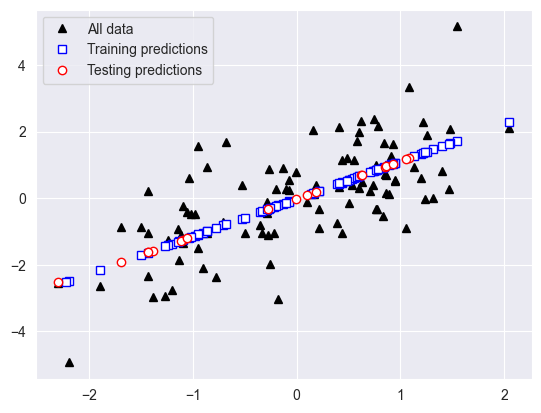

In [35]:
y_pred_train = ann_regression(X[is_in_training]).detach()
y_pred_test = ann_regression(X[~is_in_training]).detach()

plt.plot(X, y, 'k^', label="All data")
plt.plot(X[is_in_training], y_pred_train, 'bs', markerfacecolor='w', label="Training predictions")
plt.plot(X[~is_in_training], y_pred_test, 'ro', markerfacecolor='w', label="Testing predictions")
plt.legend()
plt.show()

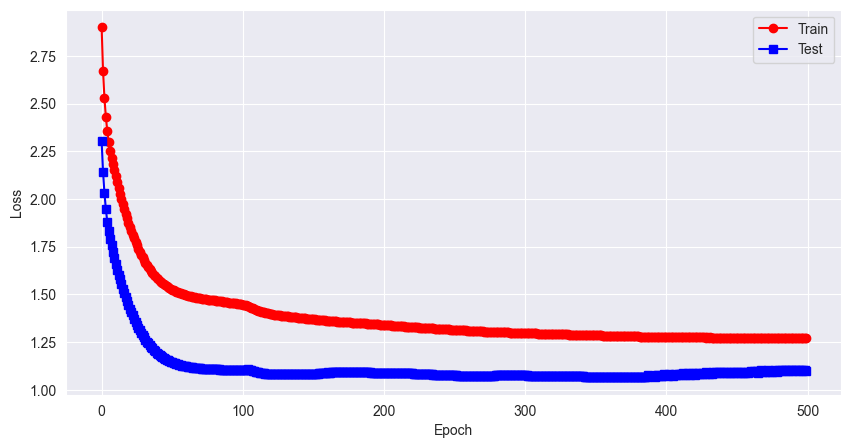

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(losses_train, 'ro-')
plt.plot(losses_test, 'bs-')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(['Train', 'Test'])
plt.show()